In [69]:
import pandas as pd
from datetime import datetime
import dateparser
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


### TO DO:
- Analyse of NaN with distribution plots
- Correlation Matrix to see which features are important
- Chi_2 score

Retours :

- Covariate shift : AUC, s’il arrive a distinguer qu’une feature appartient plus à du train que du test (70%) on supprime la feature.
- Poids de similarité : si une observation du train est proche d’une observation du test —> pondérer
- Ensemble learning : predict_proba, mettre un seuil sur la probabilité !!
- Faire du sample_weights 

In [2]:
## Read csvs
train_df = pd.read_csv('train.csv', index_col=0)
train_x = train_df[['date', 'org', 'tld', 'ccs', 'bcced', 'mail_type', 'images', 'urls',
       'salutations', 'designation', 'chars_in_subject', 'chars_in_body',]]
train_y = train_df[['label']]
test_x = pd.read_csv('test.csv', index_col=0)

In [3]:
print('Size of the training set ', train_df.shape)
print('Size of the testing set ', test_x.shape)

Size of the training set  (24840, 13)
Size of the testing set  (10647, 12)


In [5]:
## Handle missing values with median
train_x.fillna('median', inplace=True)
test_x.fillna('median', inplace=True)

### Date Feature

In [9]:
#Obtain clean date

#1. There are no missing values in the date column, but several formats exist:
#(a) Sun, 28 Aug 2016 00:17:44 +0000
#(b) 11-MAR-2018 20:40:58
#(c) Mon, 8 Apr 2013 09:59:21
#(d) 25 Apr 2019 07:13:43 -0400
#...
#2. There are also incorrect time zones values, '+0580', which I changed to '0530'

def change_date_format(X):
    X['date'] = X['date'].str.replace(r' \(.*\)', '')
    X['date'] = X['date'].str.rstrip()
    X['date'] = X['date'].str.replace('-0000', '+0000')
    X['date'] = X['date'].str.replace('0580', '0530')
    X['datetime'] = X['date'].apply(dateparser.parse, languages=['en'])
    return X

In [10]:
train_x = change_date_format(train_x)
test_x  = change_date_format(test_x)

## Binary features
- salutations
- designation
- bcced

In [110]:
l_bin_var = ['salutations', 'designation', 'bcced']

In [111]:
train_df = pd.concat([train_x, train_y], axis=1)

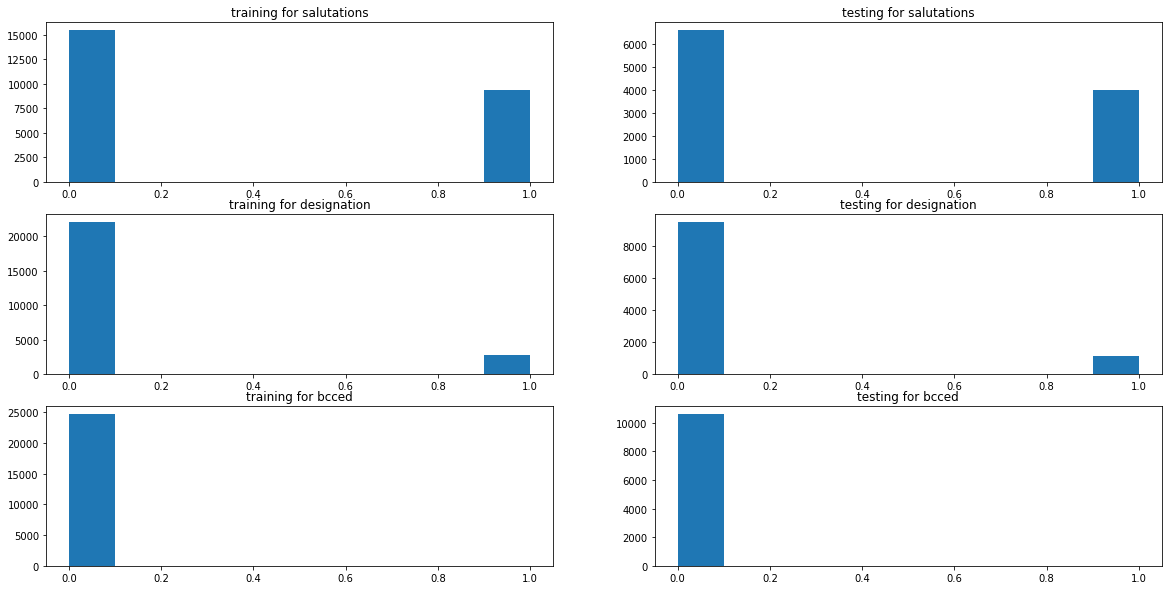

In [106]:
fig, axes = plt.subplots(3, 2, figsize=(20, 10))
for i in range(len(l_bin_var)):
    axes[i, 0].hist(train_x[l_bin_var[i]])
    title = 'training for ' + l_bin_var[i]
    axes[i, 0].set_title(title)

    axes[i, 1].hist(test_x[l_bin_var[i]])
    title = 'testing for ' + l_bin_var[i]
    axes[i, 1].set_title(title)
    
plt.show()

#### <font color='red'> We see that bcced feature always is equal to 0 in training and testing dataset

Let's check the other binary features

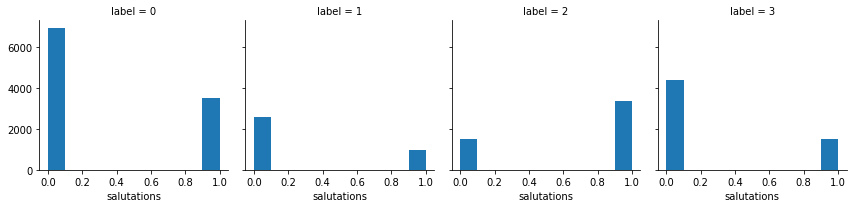

In [109]:
g = sns.FacetGrid(train_df, col="label")
g = g.map(plt.hist, "salutations", bins=10)

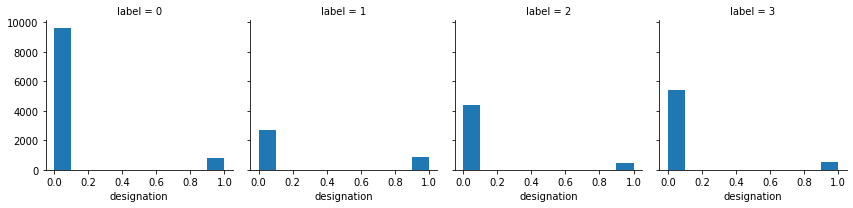

In [103]:
g = sns.FacetGrid(train_df, col="label")
g = g.map(plt.hist, "designation", bins=10)

## Continious features
- ccs
- images
- urls
- chars_in_subject
- chars_in_body

Check distribution of these variables

In [58]:
l_cont_var = ['ccs', 'images', 'urls', 'chars_in_subject', 'chars_in_body']

Distribution of continious variables for the <b> training </b> set and <b> testing </b> set

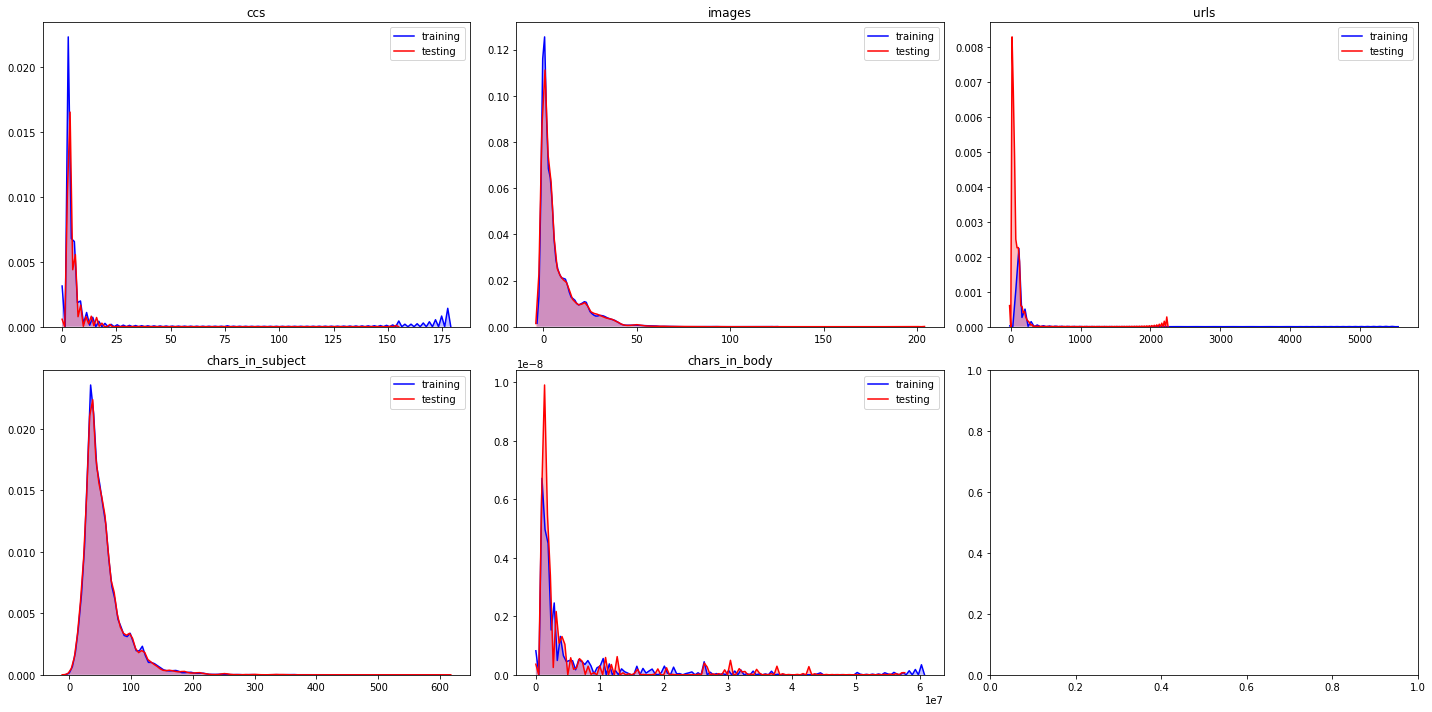

In [120]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.ravel()
for i in range(len(l_cont_var)):
    axes[i].set_title(l_cont_var[i])
    sns.kdeplot(train_x[l_cont_var[i]], shade=True, ax=axes[i], color="b", label='training', legend=True)
    sns.kdeplot(test_x[l_cont_var[i]], shade=True, ax=axes[i], color="r", label='testing', legend=True)
plt.tight_layout()    

If we normalized our data

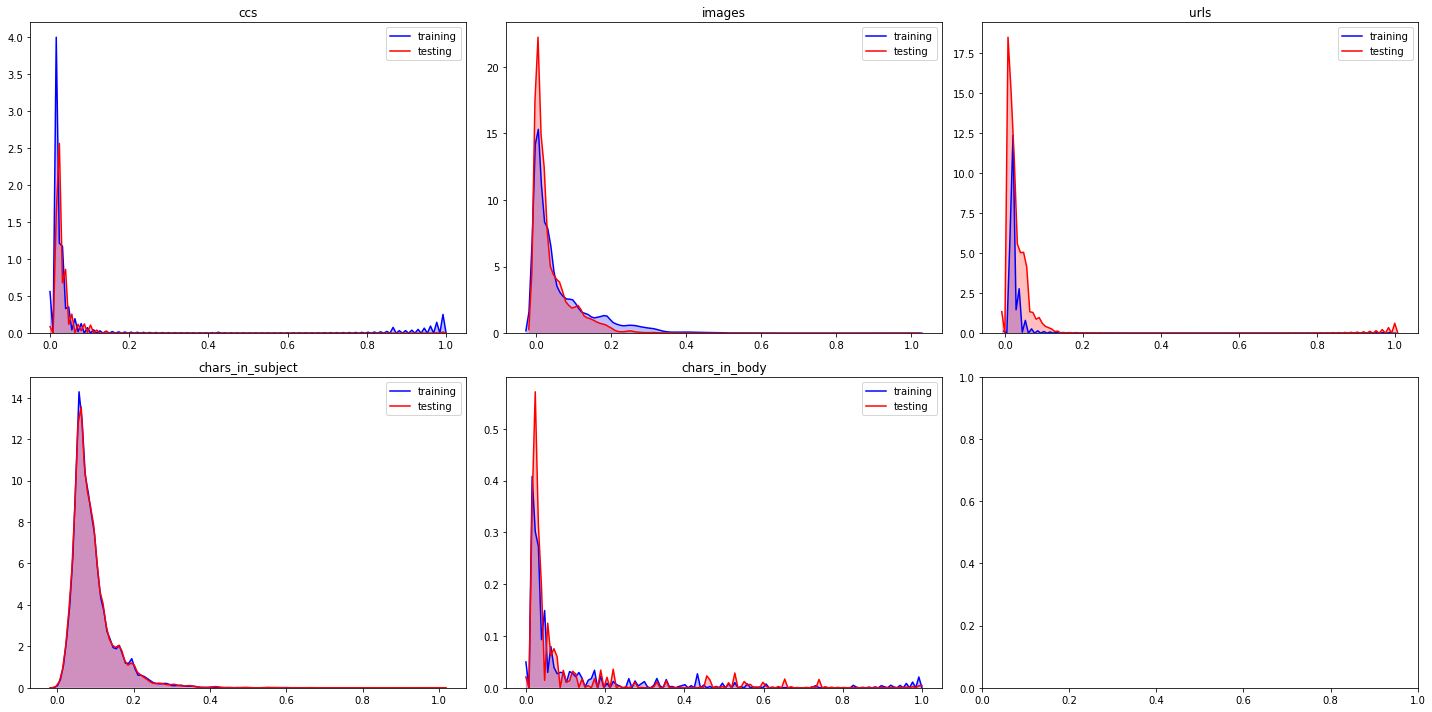

In [118]:
min_max_scaler_train = MinMaxScaler()
train_x_norm = min_max_scaler_train.fit_transform(train_x[l_cont_var])
train_x_norm = pd.DataFrame(train_x_norm, columns=l_cont_var)

min_max_scaler_test = MinMaxScaler()
test_y_norm = min_max_scaler_test.fit_transform(test_x[l_cont_var])
test_y_norm = pd.DataFrame(test_y_norm, columns=l_cont_var)

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.ravel()
for i in range(len(l_cont_var)):
    axes[i].set_title(l_cont_var[i])
    sns.kdeplot(train_x_norm[l_cont_var[i]], shade=True, ax=axes[i], color="b", label='training', legend=True)
    sns.kdeplot(test_y_norm[l_cont_var[i]], shade=True, ax=axes[i], color="r", label='testing', legend=True)
plt.tight_layout() 

In [105]:
# instantiate labelencoder object
le = LabelEncoder()
# apply le on categorical feature columns
train_x[['org']] = train_x[['org']].apply(lambda col: le.fit_transform(col))

In [100]:
feat_enc_org = OneHotEncoder()
feat_enc_org.fit(train_x[['org']])
train_x_featurized = feat_enc_org.transform(train_x[['org']])

In [4]:
## Do one hot encoding of categorical feature
feat_enc = OneHotEncoder()
feat_enc.fit(train_x)
train_x_featurized = feat_enc.transform(train_x)
test_x_featurized = feat_enc.transform(test_x)

## Train a simple KNN classifier using featurized data
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_x_featurized, train_y)
pred_y = neigh.predict(test_x_featurized)

/Users/antoineohleyer/miniconda3/envs/ipseite/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':


In [5]:
pred_df = pd.DataFrame(pred_y, columns=['label'])
pred_df.to_csv("knn_sample_submission.csv", index=True, index_label='Id')